## Data Science Case Study - Andrew Bodzsar

### Company details:
#### SolaraNova enables homeowners to finance renewable energy installations such as photovoltaic (PV) systems and heat pumps. As SolaraNova grows, underwriting efficiency, risk management, and loan pricing optimization become key to improving margins and scalability

#### Analyse the dataset containing customer loan data to:
* Evaluate credit risk factors
* Identify insights to optimize loan pricing
* Predict repayment behaviors and defaults

### Tasks:

### 1. Data Exploration and Cleaning:
* Perform basic data exploration and clean any obvious issues (missing values, outliers)
* Generate summary statistics (loan size, tenor, credit score, payment history)

### 2. Risk Profiling:
* Segment customers into 3 risk categories (low, medium, high) based on key variables:
* Credit score
* Loan amount
* Income
* others that you think are useful

### 3. Predictive Modeling:
* Build a logistic regression predictive model to estimate the default probability
* Focus on key features such as credit score, loan amount, and income-to-loan ratio
* Evaluate model performance with basic metrics (e.g., accuracy or AUC)

### 4. Data Management & Model Integration:
* Propose how you could deploy your model into a live environment, integrating it with an existing database and financial models
* Suggest any tools or frameworks that might help maintain code or schedule automated retraining

---

### Details about the data:

#### Relationships between the fields in the Loan Data table were established visually and manually, however, this would not be efficient in the case of a more extensive dataset than what was provided. In that instance, Python could be used to perform completeness analysis to uncover the equations that define the relationships between the fields. In our case, the equations were:

*  Monthly Payments: (loan_amount * (interest_rate / 1200)) / 1 - (1 + (interest_rate / 1200))^(-loan_term_months)
*  Income to loan ratio: annual_income / loan_amount
*  Loan_to_income: loan_amount / annual_income
*  Debt_to_income: current_monthly_debt / (annual_income/12)
*  Payment_to_income: monthly_payment / (annual_income/ 12)
*  Loan_to_value: loan_amount / property_value
*  Savings_coverage_ratio: estimated_monthly_Savings / monthly_payment
*  Average_days_late: average of days_late inside payment_history table
*  Max_days_late: max(days_late) inside payment_history table
*  Avg_payment: (sum(amount_paid in payment_history table) / number of payments inside payment_history table per customer_id)
*  Payment_std: sample standard deviation formulae on amount_paid per customer_id in payment_history table
* Days_late in payment_history table: payment_date - due_date



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve

In [2]:
try:
    loan_data = pd.read_excel('loandata_table.xlsx')
    payment_data = pd.read_excel('payment_history.xlsx')
    schufa_data = pd.read_excel('schufa_credit_rating.xlsx') 
except Exception as e:
    print(f"File reading error: {e}")


In [3]:
""" Section 1 """

# Function to analyze missing values
def missing_values(df, title):
    missing_count = df.isnull().sum()  # DataSeries summary of nu of missing vals per rec
    if missing_count.sum() == 0:
        return f"No missing values found in the table/field: {title}"
    missing_percentage = (missing_count / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing Percentage': missing_percentage
    }).sort_values('Missing Percentage', ascending=False)  # DataFrame view, sorted desc.
    
    missing_df = missing_df[missing_df['Missing Count'] > 0]  # Complete rows filtered out
    return missing_df

loandata_missing = missing_values(loan_data, "Loan Data")
print(loandata_missing)
payment_missing = missing_values(payment_data, "Payment History")
print(payment_missing)
schufa_missing = missing_values(schufa_data, "Schufa PD 12 Disribution")
print(schufa_missing)

                    Missing Count  Missing Percentage
employment_years               55                 5.5
credit_utilization             52                 5.2
property_value                 48                 4.8
No missing values found in the table/field: Payment History
No missing values found in the table/field: Schufa PD 12 Disribution


In [4]:
#Comparing DF fields
def compare_old_new_field(df_old, df_new):
    df_complete = pd.DataFrame({
            'Old data': df_old,
            'New data': df_new
        })
    df_filtered = df_complete[df_complete['Old data'].isnull()]
    print("\nComparison of missing and new values:")
    return df_filtered



In [5]:


def fill_property_value_from_ltv(df):
    """ Filling the property_value field's empty values by
    rearranging the loan_to_value = loan_amount / property_value equation """
    loan_data_original_copy = loan_data.copy()
    
    # Find rows with missing property_value but existing loan_amount and loan_to_value
    mask = (df['property_value'].isnull() & 
            df['loan_amount'].notnull() & 
            df['loan_to_value'].notnull() &
            df['loan_to_value'] > 0)

    print("Filling in property values...")
    # Calculate property_value = loan_amount / loan_to_value
    df.loc[mask, 'property_value'] = (
        df.loc[mask, 'loan_amount'] / df.loc[mask, 'loan_to_value']
    )

    print("Check for missing property values after update:")
    print(missing_values(df['property_value'], "Property Value Field"))

    try:
        comparison_propertyval = compare_old_new_field(loan_data_original_copy['property_value'], df['property_value'])
        if comparison_propertyval.empty:
            print("No differences found. The data has probably been cleaned already")
        else:
            print(comparison_propertyval)
    except Exception as e:
        print(f"Error during comparison: {e}")

fill_property_value_from_ltv(loan_data)

Filling in property values...
Check for missing property values after update:
No missing values found in the table/field: Property Value Field

Comparison of missing and new values:
     Old data  New data
4         NaN  180390.0
50        NaN  110501.0
77        NaN  121614.0
78        NaN  184944.0
88        NaN  237995.0
89        NaN  179369.0
108       NaN  284185.0
117       NaN  143084.0
134       NaN  141694.0
144       NaN  232118.0
207       NaN  164618.0
268       NaN  292107.0
270       NaN  239137.0
273       NaN  181990.0
281       NaN  248101.0
362       NaN  158869.0
367       NaN  149215.0
437       NaN  200377.0
438       NaN  343700.0
445       NaN  199145.0
462       NaN  250230.0
465       NaN  105171.0
498       NaN  135529.0
500       NaN  297643.0
503       NaN  137019.0
525       NaN  189733.0
580       NaN  124368.0
590       NaN  183159.0
601       NaN  205688.0
607       NaN  100000.0
612       NaN  197782.0
623       NaN  158826.0
650       NaN  142025.0
65

In [6]:
def fill_credit_utilization_by_credit_lines(df):
    loan_data_original_copy = loan_data.copy()  # For comparison
    
    # Median of each credit utilisation group is calculated
    medians = df.groupby('num_credit_lines')['credit_utilization'].median()
    
    # Updating empty records with claculated values
    print("Filling credit utilisation values... ")
    for credit_lines, median_value in medians.items():
        mask = (df['credit_utilization'].isnull() & 
                (df['num_credit_lines'] == credit_lines))
        df.loc[mask, 'credit_utilization'] = median_value

    try:
        comparison_creditut = compare_old_new_field(loan_data_original_copy['credit_utilization'], df['credit_utilization'])
        if comparison_creditut.empty:
            print("No differences found. The data has probably been cleaned already")
        else:
            print(comparison_creditut)
    except Exception as e:
        print(f"Error during comparison: {e}")
    

fill_credit_utilization_by_credit_lines(loan_data)

Filling credit utilisation values... 

Comparison of missing and new values:
     Old data  New data
46        NaN  0.385203
63        NaN  0.363653
65        NaN  0.363653
76        NaN  0.363653
94        NaN  0.385203
103       NaN  0.380975
110       NaN  0.363653
131       NaN  0.380975
154       NaN  0.380975
180       NaN  0.434286
196       NaN  0.363653
203       NaN  0.363653
206       NaN  0.434286
280       NaN  0.385203
288       NaN  0.363653
321       NaN  0.385203
323       NaN  0.434286
336       NaN  0.407920
409       NaN  0.385203
430       NaN  0.385203
435       NaN  0.407920
448       NaN  0.363653
511       NaN  0.363653
545       NaN  0.385203
547       NaN  0.380975
549       NaN  0.363653
557       NaN  0.407920
568       NaN  0.363653
590       NaN  0.363653
595       NaN  0.380975
596       NaN  0.380975
625       NaN  0.363653
643       NaN  0.428111
663       NaN  0.428111
681       NaN  0.434286
688       NaN  0.434286
707       NaN  0.428111
718       N

In [7]:
def fill_missing_employment_years(df):
    """ Cap data where employment years exceed (age - 18); add averages where e_y = 0 or empty """
    loan_data_original_copy = loan_data.copy()  # For comparison
    
    # Checking if employment years exceed (age - 18) then capping them
    invalid_mask = (df['employment_years'].notnull()) & (df['employment_years'] > (df['age'] - 18)) & (df['age'] >= 18)
    invalid_count = invalid_mask.sum()  # Count occurences
    df.loc[invalid_mask, 'employment_years'] = df.loc[invalid_mask, 'age'] - 18  # Updating values
    
    # To fill empty values, we average the nu of employment years per age group
    df['age_decade'] = ((df['age'] // 10) * 10)  # Floor division, divide then round down
    # Use only valid data (not missing and not exceeding age-18) for reference averages
    valid_mask = (df['employment_years'].notnull()) & (df['employment_years'] <= (df['age'] - 18))
    decade_averages = df[valid_mask].groupby('age_decade')['employment_years'].mean()
    print("\nAverage employment years by age decade:")  # Print age decade averages for reference
    for decade, avg in decade_averages.items():
        print(f"Age {decade}-{decade+9}: {avg:.2f} years")
    
    # Identify rows with missing or zero employment_years
    missing_mask = df['employment_years'].isnull()
    zero_mask = df['employment_years'] == 0
    needs_fill_mask = missing_mask | zero_mask

    print("Filling employment_years values... ")
    for decade, avg in decade_averages.items():  # Replace data
        decade_mask = needs_fill_mask & (df['age_decade'] == decade)
        df.loc[decade_mask, 'employment_years'] = avg

    try:
        comparison_employment = compare_old_new_field(loan_data_original_copy['employment_years'], df['employment_years'])
        if comparison_employment.empty:
            print("No differences found. The data has probably been cleaned already")
        else:
            print(comparison_employment)
    except Exception as e:
        print(f"Error during comparison: {e}")
    
    

fill_missing_employment_years(loan_data)


Average employment years by age decade:
Age 20-29: 7.44 years
Age 30-39: 9.15 years
Age 40-49: 9.43 years
Age 50-59: 10.09 years
Age 60-69: 9.54 years
Age 70-79: 7.00 years
Filling employment_years values... 

Comparison of missing and new values:
     Old data   New data
0         NaN   9.430939
51        NaN   9.430939
59        NaN  10.091324
70        NaN   9.430939
73        NaN   9.539683
77        NaN   9.430939
101       NaN   9.430939
116       NaN   9.430939
123       NaN   9.154812
128       NaN   9.430939
134       NaN   9.154812
137       NaN   9.430939
164       NaN  10.091324
188       NaN   9.154812
250       NaN   9.154812
252       NaN   9.539683
264       NaN   9.430939
300       NaN   9.154812
322       NaN   9.154812
360       NaN  10.091324
363       NaN   9.430939
384       NaN   9.154812
409       NaN  10.091324
410       NaN  10.091324
426       NaN   9.154812
453       NaN  10.091324
454       NaN   9.154812
486       NaN   9.154812
489       NaN  10.091324
5

In [8]:
""" Summary statistics """
def loan_size(df):
    print("LOAN SIZE")
    loan_size_stats = df['loan_amount'].describe()
    print(f"We've got {int(loan_size_stats['count'])} loans ranging from €{loan_size_stats['min']:.0f} to €{loan_size_stats['max']:.0f}")
    print(f"Average loan: €{loan_size_stats['mean']:.0f}")
    print(f"Typical loan (median): €{loan_size_stats['50%']:.0f}")

    print("\nBREAKPOINTS:")
    print(f"Bottom 10% are under €{df['loan_amount'].quantile(0.1):.0f}")
    print(f"Bottom 25% are under €{df['loan_amount'].quantile(0.25):.0f}")
    print(f"Top 25% are over €{df['loan_amount'].quantile(0.75):.0f}")
    print(f"Top 10% are over €{df['loan_amount'].quantile(0.9):.0f}")
    
    print(f"\nAverage cost per kW for installed system capacities: €{df['loan_amount'].sum() / df['system_size_kw'].sum():.0f}")

def tenor(df):
    print("\nTENOR")
    term_counts = df.groupby('loan_term_months').size()
    
    # Get average rates for each term length
    rates_by_term = df.groupby('loan_term_months')['interest_rate'].mean()
    
    print(f"BASICS:")
    print(f"Average term: {df['loan_term_months'].mean():.1f} months")
    print(f"Most common term: {term_counts.idxmax()} months ({term_counts.max()} loans)")

    print("\nTERM BREAKDOWN:")
    for term, count in term_counts.sort_index().items():
        pct = count/len(df)*100
        rate = rates_by_term[term]
        print(f"{term} months: {count} loans ({pct:.1f}%) at {rate:.2f}% avg rate")

def payment_history(loan_data, payment_history):
    print("PAYMENT HISTORY")
    days_late = loan_data['avg_days_late'].describe()
    payment_var = loan_data['payment_std'].describe()
    
    print(f"\nTIMELINESS:")
    print(f"Typical customer is {days_late['50%']:.1f} days late on average")
    print(f"About 25% of customers average over {days_late['75%']:.1f} days late")
    q90_days_late = loan_data['avg_days_late'].quantile(0.9)
    print(f"Worst 10% average {q90_days_late:.1f}+ days late")

loan_size(loan_data)
tenor(loan_data)
payment_history(loan_data, payment_data)

LOAN SIZE
We've got 1000 loans ranging from €10000 to €49786
Average loan: €24802
Typical loan (median): €24606

BREAKPOINTS:
Bottom 10% are under €14035
Bottom 25% are under €19202
Top 25% are over €30378
Top 10% are over €35150

Average cost per kW for installed system capacities: €3088

TENOR
BASICS:
Average term: 113.8 months
Most common term: 120 months (523 loans)

TERM BREAKDOWN:
60 months: 290 loans (29.0%) at 5.56% avg rate
120 months: 523 loans (52.3%) at 5.51% avg rate
180 months: 187 loans (18.7%) at 5.48% avg rate
PAYMENT HISTORY

TIMELINESS:
Typical customer is 2.0 days late on average
About 25% of customers average over 3.5 days late
Worst 10% average 6.0+ days late



Risk Category Distribution:
risk_category
Medium    512
High      282
Low       206
Name: count, dtype: int64

Default Rate by Risk Category:
  risk_category  count  defaults  default_rate_pct
0          High    282        28          9.929078
1           Low    206         0          0.000000
2        Medium    512         3          0.585938

Key Metrics by Risk Category:
  risk_category  schufa_score  annual_income   loan_amount  debt_to_income  \
0          High   9083.595745   51557.989362  26781.705674        0.247024   
1           Low   9413.514563  102431.839806  21724.873786        0.096190   
2        Medium   9178.214844   67715.037109  24950.369141        0.157208   

   avg_days_late  
0       3.043735  
1       2.023867  
2       2.648926  


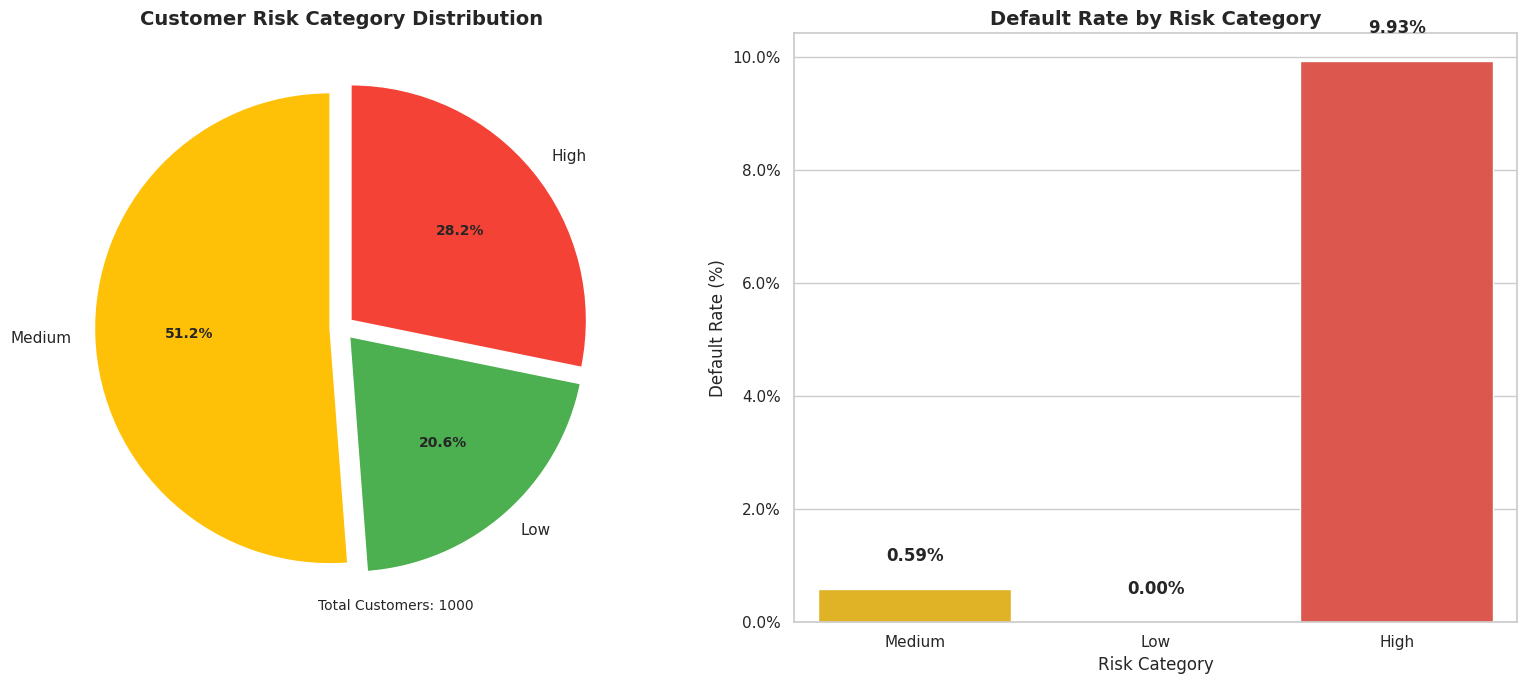

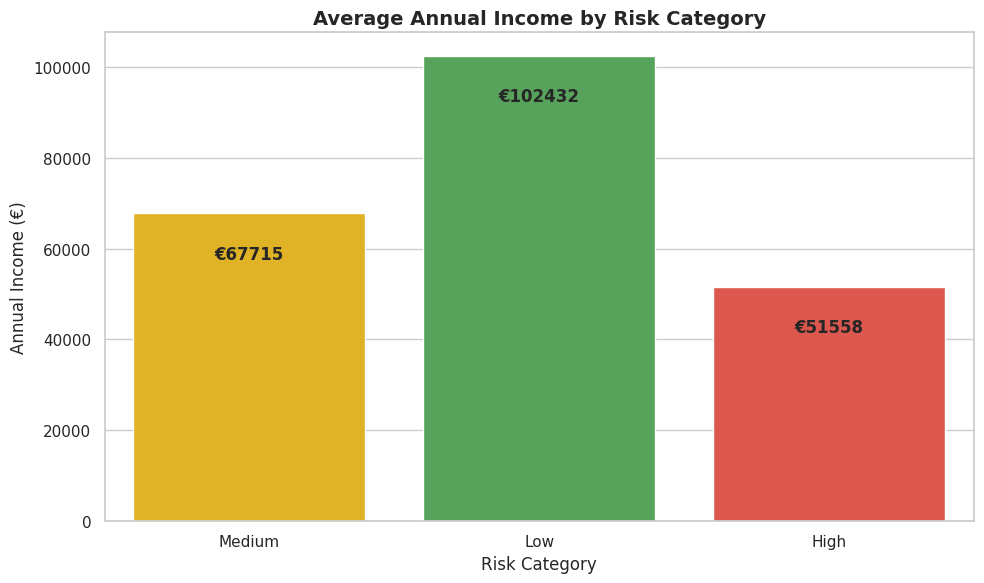

In [9]:
""" Section 2 """
def calculate_risk_score(df):
    """ Setting up a score based categorisation system for Low, Medium or High risk customers"""
    
    # Initialize risk score column
    df['risk_score'] = 0
    
    # Credit Score
    df.loc[df['schufa_score'] < 7500, 'risk_score'] += 30
    df.loc[(df['schufa_score'] >= 7500) & (df['schufa_score'] < 8500), 'risk_score'] += 20
    df.loc[(df['schufa_score'] >= 8500) & (df['schufa_score'] < 9000), 'risk_score'] += 10
    
    # Debt-to-Income Ratio
    df.loc[df['debt_to_income'] > 0.3, 'risk_score'] += 30
    df.loc[(df['debt_to_income'] > 0.15) & (df['debt_to_income'] <= 0.3), 'risk_score'] += 15
    df.loc[(df['debt_to_income'] > 0.05) & (df['debt_to_income'] <= 0.15), 'risk_score'] += 5
    
    # Late Payments
    df.loc[df['late_payments_30'] > 3, 'risk_score'] += 20
    df.loc[(df['late_payments_30'] > 0) & (df['late_payments_30'] <= 3), 'risk_score'] += 10
    df.loc[df['late_payments_90'] > 0, 'risk_score'] += 30
    
    # Average Days Late
    df.loc[df['avg_days_late'] > 10, 'risk_score'] += 20
    df.loc[(df['avg_days_late'] > 3) & (df['avg_days_late'] <= 10), 'risk_score'] += 10
    
    # Previous Defaults
    df.loc[df['previous_defaults'] > 0, 'risk_score'] += 40
    
    # Income-to-Loan Ratio
    df.loc[df['income_to_loan_ratio'] < 2, 'risk_score'] += 20
    df.loc[(df['income_to_loan_ratio'] >= 2) & (df['income_to_loan_ratio'] < 3.5), 'risk_score'] += 10
    
    # Categorise the customers
    df['risk_category'] = 'Medium'
    df.loc[df['risk_score'] < 20, 'risk_category'] = 'Low'
    df.loc[df['risk_score'] >= 50, 'risk_category'] = 'High'
    
    return df
    
# Call the function
loan_data_with_risk = calculate_risk_score(loan_data)

# Number of customers per category
risk_distribution = loan_data_with_risk['risk_category'].value_counts()
print("\nRisk Category Distribution:")
print(risk_distribution)

# Default rate by risk category
default_by_risk = loan_data_with_risk.groupby('risk_category').agg({
    'default_flag': ['count', 'sum', lambda x: (x.sum() / x.count()) * 100]
}).reset_index()
default_by_risk.columns = ['risk_category', 'count', 'defaults', 'default_rate_pct']
print("\nDefault Rate by Risk Category:")
print(default_by_risk)

# Evaluate categories on metrics of:
key_metrics_by_risk = loan_data_with_risk.groupby('risk_category').agg({
    'schufa_score': 'mean',
    'annual_income': 'mean',
    'loan_amount': 'mean',
    'debt_to_income': 'mean',
    'avg_days_late': 'mean'
}).reset_index()
print("\nKey Metrics by Risk Category:")
print(key_metrics_by_risk)

# Diagrams

sns.set(style="whitegrid")
colors = {'Low': '#4CAF50', 'Medium': '#FFC107', 'High': '#F44336'}
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# 1. Risk Distribution - Pie Chart
risk_counts = risk_distribution.sort_index(ascending=False)  # Sort so Low, Medium, High
explode = (0.05, 0.05, 0.05)  # make all slices slightly separated
wedges, texts, autotexts = ax[0].pie(
    risk_counts, 
    explode=explode,
    labels=risk_counts.index, 
    autopct='%1.1f%%',
    colors=[colors[cat] for cat in risk_counts.index],
    startangle=90
)
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_weight('bold')
ax[0].set_title('Customer Risk Category Distribution', fontsize=14, fontweight='bold')
ax[0].text(-0.1, -1.2, f'Total Customers: {loan_data_with_risk.shape[0]}', fontsize=10)

# 2. Default Rate by category - Bar Chart
sorted_default = default_by_risk.sort_values('risk_category', ascending=False)  # Sort so Low, Medium, High
sns.barplot(
    x='risk_category', 
    y='default_rate_pct',
    hue='risk_category',
    data=sorted_default,
    palette=colors,
    legend=False,
    ax=ax[1]
)
ax[1].set_title('Default Rate by Risk Category', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Risk Category')
ax[1].set_ylabel('Default Rate (%)')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())

for i, v in enumerate(sorted_default['default_rate_pct']):
    ax[1].text(i, v + 0.5, f'{v:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()

# 3. Annual income by category
sorted_metrics = key_metrics_by_risk.sort_values('risk_category', ascending=False)
plt.figure(figsize=(10, 6))
income_plot = sns.barplot(
    x='risk_category', 
    y='annual_income',
    hue='risk_category',
    data=sorted_metrics, 
    palette=colors,
    legend=False
)

for i, v in enumerate(sorted_metrics['annual_income']):
    plt.text(i, v-10000, f'€{v:.0f}', ha='center', fontweight='bold')

plt.title('Average Annual Income by Risk Category', fontsize=14, fontweight='bold')
plt.xlabel('Risk Category')
plt.ylabel('Annual Income (€)')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

Accuracy: 0.9867
AUC: 0.9966

Confusion Matrix:
[[287   4]
 [  0   9]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       291
           1       0.69      1.00      0.82         9

    accuracy                           0.99       300
   macro avg       0.85      0.99      0.91       300
weighted avg       0.99      0.99      0.99       300


Feature Importance:
                       Feature  Coefficient  Abs_Coefficient
1                 schufa_score    -3.373655         3.373655
0             late_payments_90     3.076882         3.076882
3                max_days_late    -0.719388         0.719388
6             loan_term_months     0.342558         0.342558
4                          age    -0.237824         0.237824
2            previous_defaults     0.176005         0.176005
8  estimated_annual_production     0.112507         0.112507
5           credit_utilization     0.097504         0.097504
9       

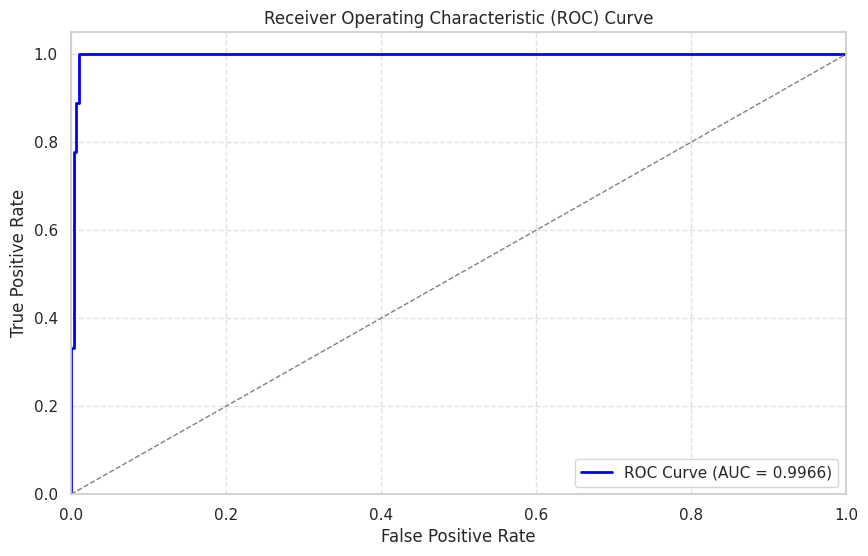

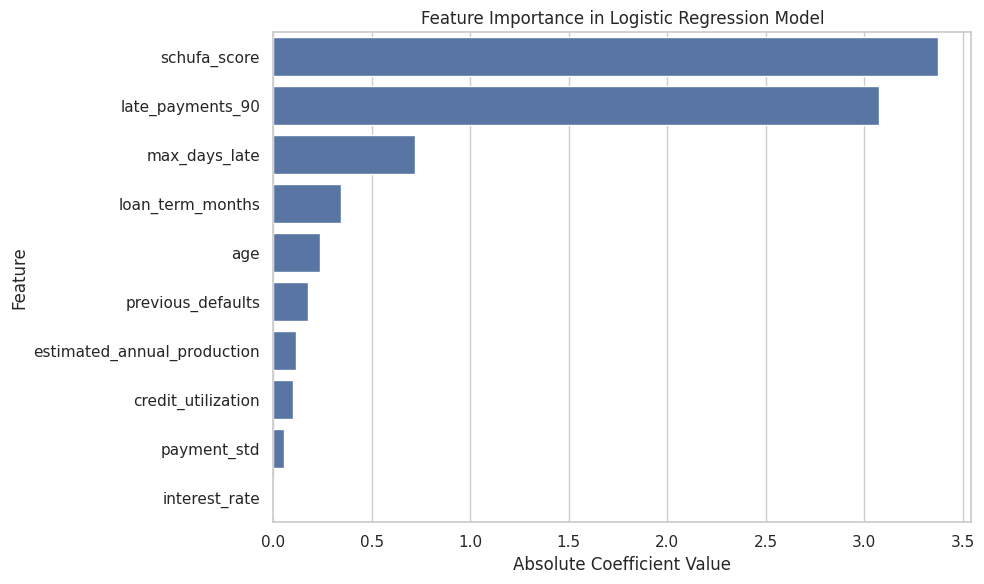

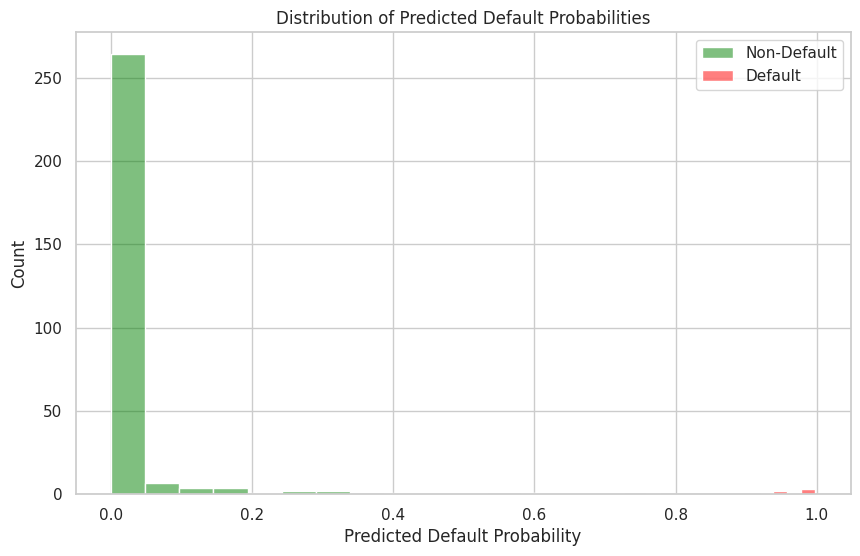

In [10]:
""" Section 3 """

# first select the features which are used to train the model on
features = [
    'late_payments_90',        
    'schufa_score',            
    'previous_defaults',       
    'max_days_late',          
    'age',                     
    'credit_utilization',      
    'loan_term_months',        
    'interest_rate',           
    'estimated_annual_production', 
    'payment_std',            
]


X = loan_data[features]
y = loan_data['default_flag']

# Then we split the available data into test and training datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42,
                                                    stratify=y) 

# Then we transform datasets to get results with mean=0 and sd=1
scaler = StandardScaler()  # Normalises features to mean=0, std=1, handles outliers better
X_train_scaled = scaler.fit_transform(X_train)  # calculates mean and sd for each feature
                        # as well as transforms by subtracting its mean and dividing by its sd
X_test_scaled = scaler.transform(X_test)  # only .transform on test to prevent data leakage


# Build logistic regression model
log_reg = LogisticRegression(random_state=42,
                             max_iter=1000,
                             class_weight='balanced')  # Handles imbalance by adjusting weights
                                                       # inveresely proportional to class freq.
# Then we train the logistic regression model which 
# fits a sigmoid function to transform a linear combination of features to probability
# This means finding optimal coefficients that maximise the likelihood of the observed outcomes
# The model learns how each feature relates to the probability of default.
log_reg.fit(X_train_scaled, y_train)

# Then we make predictions for the defaults and extract the probabilities of defaults
# which are then converted to binary values using a threshold. 
y_pred_prob = log_reg.predict_proba(X_test_scaled)[:, 1]  # Probability of default
y_pred = log_reg.predict(X_test_scaled)  # Binary classification

# Model performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': log_reg.coef_[0],
    'Abs_Coefficient': abs(log_reg.coef_[0])
})
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Display ROC curve
plt.figure(figsize=(10, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Display Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Importance in Logistic Regression Model')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Probability distribution 
plt.figure(figsize=(10, 6))
sns.histplot(x=y_pred_prob[y_test == 0], bins=20, alpha=0.5, color='green', label='Non-Default')
sns.histplot(x=y_pred_prob[y_test == 1], bins=20, alpha=0.5, color='red', label='Default')
plt.xlabel('Predicted Default Probability')
plt.ylabel('Count')
plt.title('Distribution of Predicted Default Probabilities')
plt.legend()
plt.show()

""" Section 4"""
# Application Deployment Plan

This document outlines the plan for deploying the Python application, including frontend/backend communication, data flow, deployment stack, CI/CD, and maintenance strategies.

## Frontend to Backend Communication

*   **Method:** Standard HTTP requests from the frontend to the Flask backend API.
*   **Frontend:** Vanilla JavaScript or a basic framework (potentially Server-Side Rendered). A framework like `React`, `Vue`, or `Angular` can be used for more complex use cases.
*   **Data Format:** JSON for data exchange between frontend and backend.
*   **API:** Browser's Fetch API used for making requests.
*   **Headers:** Requests include appropriate headers (e.g., `Content-Type`, `Authorization`).
*   **Backend API:** `Flask` backend exposes RESTful endpoints for:
    *   User authentication
    *   Application submission
    *   Application status checking
    *   Viewing results (data retrieved from the database)

## Data Flow Process

1.  **Submission:** User submits application data via the frontend form.
2.  **Frontend Validation:** Basic client-side validation (format, completeness).
3.  **Backend Submission:** Data sent as a JSON payload to the backend submission endpoint.
4.  **Backend Security Validation:**
    *   Input sanitization (prevent SQL injection).
    *   Data type validation.
    *   Range checking (numeric values).
    *   Pattern matching (e.g., emails, phone numbers).
    *   Authorization checks.
5.  **Data Cleaning:** Python scripts perform data cleaning routines.
6.  **Data Storage:** Cleaned data is stored in `PostgreSQL`.
7.  **ML Processing (Risk Assessment & Default Prediction):**
    *   Relevant data is pulled from `PostgreSQL`.
    *   Risk assessment service runs.
    *   Default prediction service runs.
    *   Results from both services are saved back to `PostgreSQL`.

This makes the process asynchronous, preventing the initial HTTP request from timing out and improving user experience. The backend endpoint would enqueue the task and return an immediate "processing started" response.

8.  **Status Checking & Results:**
    *   Frontend periodically requests processing status.
    *   Backend queries `PostgreSQL` for the current status (e.g., submitted, cleaning, assessed).
    *   Once complete, the frontend requests the final results.
    *   Backend retrieves necessary data from `PostgreSQL`, controlling which information is sent back.
    *   Frontend displays permitted results.
    *   Websockets can be used for real-time bi-directional client-server communication and status updates without constant polling 

## Tooling

*   **Frontend Visualization:** JavaScript libraries like `D3.js` or `Chart.js`.
*   **ORM:** `SQLAlchemy` for interacting with `PostgreSQL` using Python objects.
*   **Database GUI:** `pgAdmin` for easier database interaction during development/debugging.
*   **Database Migrations:** `Alembic` (often used with `SQLAlchemy`) to manage database schema changes over time.

## Deployment & CI/CD Stack

*   **Web Server Gateway Interface (WSGI):** `Gunicorn`.
*   **Reverse Proxy / Load Balancer:** `Nginx`.
*   **Database Driver:** `psycopg2` (for Python-PostgreSQL interaction).
*   **Containerization:**
    *   `Docker`: To containerize the application components (backend, potentially frontend, ML services).
    *   `Docker Compose`: For defining and running multi-container Docker applications during development and testing.
*   **Orchestration:** `Kubernetes` for deployment, scaling, and management in production for large-scale or high-availability needs. For simpler deployments, `Docker Compose` (potentially on a single host or using managed services like AWS ECS Fargate or Google Cloud Run) might suffice initially
*   **CI/CD Automation:** `Jenkins` for automating testing, builds, and deployments. Alternatives like **`GitLab CI/CD`** or **`GitHub Actions`** are also very popular and integrate tightly with their respective platforms.
*   **Monitoring:** `Prometheus` (metrics collection) and `Grafana` (visualization and dashboarding).
    *   Covers API performance, database metrics, error rates, system health.
*   **Logging:** **ELK Stack** (`Elasticsearch`, `Logstash`, `Kibana`) for centralized log aggregation and analysis. Often used alongside `Prometheus`/`Grafana`.
*   **Error Tracking:** `Sentry` for real-time application error and exception tracking. Complements logging and monitoring by focusing specifically on application-level exceptions, providing stack traces and context.
*   **Infrastructure as Code (IaC):** `Terraform` or `Ansible` to define and manage the underlying infrastructure (servers, databases, network rules, Kubernetes clusters) in code, ensuring consistency and repeatability.
*   **Secrets Management:**
    *   Secrets (database passwords, API keys, certificates) will be managed securely (e.g., `HashiCorp Vault`, `AWS Secrets Manager`, `Google Secret Manager`, `Kubernetes Secrets`).

## Code Maintenance & Automated ML Retraining

*   **Code Quality:**
    *   `Black`: Automated code formatting.
    *   `Flake8` or `Pylint`: Code linting (style and error checking).
*   **Security Scanning:** `Bandit` for identifying common security vulnerabilities in Python code.
*   **Documentation:** `Sphinx` for generating documentation from code comments/docstrings.
*   **Testing:** `pytest` for unit, integration, and potentially end-to-end tests.
*   **ML Lifecycle Management:** `MLflow` for tracking experiments, packaging models, and managing the model lifecycle.
*   **Workflow Orchestration / Scheduling:** `Apache Airflow` for scheduling and managing complex workflows, particularly model retraining pipelines.
*   **Distributed Computing (for large-scale ML/Data):**
    *   `Dask`: For parallelizing `Pandas`/`NumPy` operations and general distributed computing.
    *   `Ray`: For distributed applications, particularly focused on machine learning workloads.
    *   `Dask` and `Ray` are necessary only if dealing with datasets or models too large/complex for a single machine to handle efficiently.